# Implementation 4 - Multiple linear regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 
import seaborn as sns

## Importing the data set

This data set is composed of records of money (in k€) invested in TV, radio and newspaper ads for specific products and the corresponding sales (in m$).

In [2]:
data = pd.read_csv("Advertising.csv", index_col=0)
data.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


## Data inspection

In [3]:
correlation = data.corr()
correlation

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


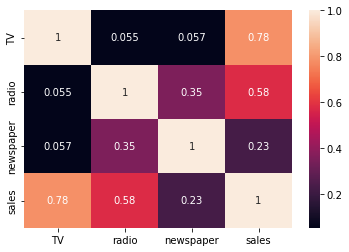

In [4]:
_ = sns.heatmap(correlation, annot=True)

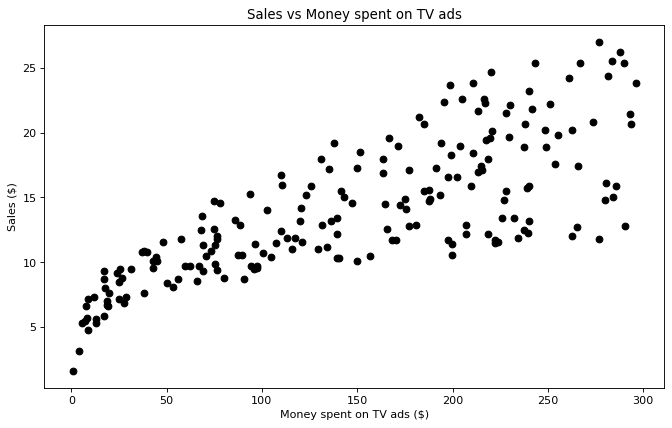

In [5]:
plt.figure(figsize=(10,6), dpi= 80)
plt.scatter(data['TV'], data['sales'], c='black')
plt.xlabel("Money spent on TV ads ($)")
plt.ylabel("Sales ($)")
plt.title("Sales vs Money spent on TV ads")
plt.show()

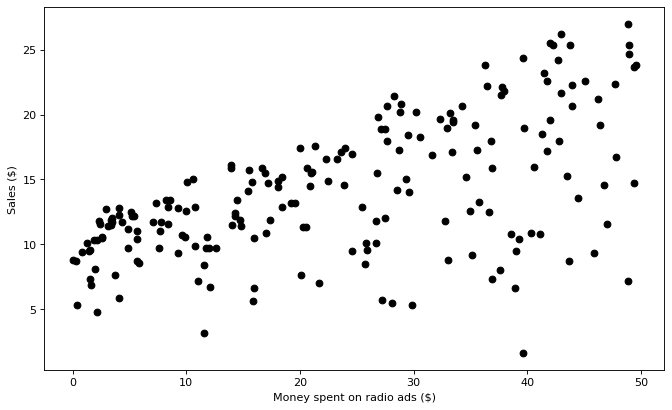

In [6]:
plt.figure(figsize=(10,6), dpi= 80)
plt.scatter(data['radio'], data['sales'], c='black')
plt.xlabel("Money spent on radio ads ($)")
plt.ylabel("Sales ($)")
plt.show()

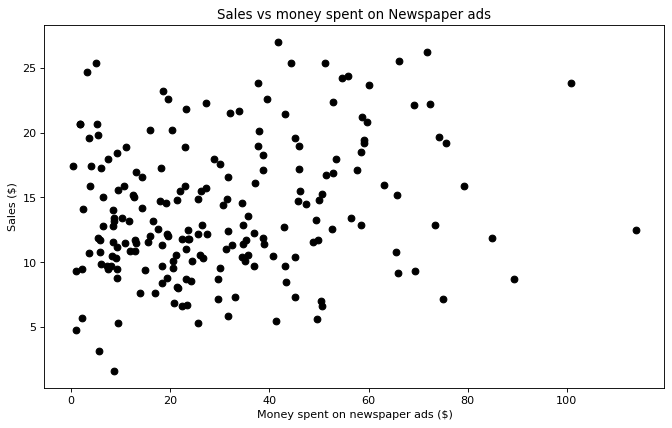

In [7]:
plt.figure(figsize=(10,6), dpi= 80)
plt.scatter(data['newspaper'], data['sales'], c='black')
plt.xlabel("Money spent on newspaper ads ($)")
plt.ylabel("Sales ($)")
plt.title("Sales vs money spent on Newspaper ads")
plt.show()

We notice from data inspection that 'sales' seems correlated with 'TV' and 'radio'.<br>
In this section, we will consider several features and the sales as the response.

## Data preparation

In [8]:
X = data.drop('sales', axis=1)
y = data['sales'].values.reshape(-1,1)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Single linear regression (reminder of ML_course03_implem)

In [10]:
X_train_single = X_train[['TV']]
X_val_single = X_val[['TV']]

### Model fit

In [11]:
from sklearn.linear_model import LinearRegression
reg_single = LinearRegression()
reg_single.fit(X_train_single, y_train)
print("The linear model is: Y = {:.2}  +  {:.2} * TV".format(reg_single.intercept_[0], reg_single.coef_[0][0]))

The linear model is: Y = 7.2  +  0.046 * TV


### Prediction Quality

In [12]:
y_single_pred = reg_single.predict(X_val_single)

In [13]:
from sklearn.metrics import r2_score

def evaluate_regression(y_pred, y_val):
    y_pred = y_pred.squeeze()
    y_val = y_val.squeeze()
    print("Mean square error (MSE): %.2f" % np.mean((y_pred - y_val) ** 2))
    print("Root mean square error (RMSE): %.2f" % np.sqrt(np.mean((y_pred - y_val) ** 2)))
    print("Mean absolute error (MAE): %.2f" % np.mean(abs(y_pred - y_val)))
    print("Coefficient of determination (R^2): %.2f" % r2_score(y_val, y_pred))

evaluate_regression(y_single_pred, y_val)

Mean square error (MSE): 8.73
Root mean square error (RMSE): 2.95
Mean absolute error (MAE): 2.30
Coefficient of determination (R^2): 0.69


## Multiple linear regression

### Model fit

In [14]:
reg_multiple = LinearRegression()
reg_multiple.fit(X_train, y_train)
print("The linear model is: Y = {:.2}  +  {:.2} * TV  +  {:.2} * radio  +  {:.2} * newspaper".format(reg_multiple.intercept_[0], reg_multiple.coef_[0][0], reg_multiple.coef_[0][1], reg_multiple.coef_[0][2]))

The linear model is: Y = 2.9  +  0.044 * TV  +  0.2 * radio  +  0.0012 * newspaper


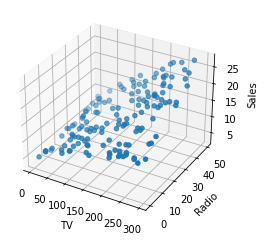

In [15]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(X_train['TV'], X_train['radio'], y_train.squeeze())
ax.set_xlabel('TV')
ax.set_ylabel('Radio')
ax.set_zlabel('Sales')
plt.show()

### Prediction Quality

In [16]:
y_pred = reg_multiple.predict(X_val)

evaluate_regression(y_pred, y_val)

Mean square error (MSE): 4.01
Root mean square error (RMSE): 2.00
Mean absolute error (MAE): 1.30
Coefficient of determination (R^2): 0.86


## Polynomial regression

### Polynomial features based on TV feature only

#### What do the polynomial features look like?

In [17]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_single_poly = poly.fit_transform(X_train_single)

X_train_single_poly = pd.DataFrame(X_train_single_poly, columns=poly.get_feature_names_out())
X_train_single_poly.head()

,TV,TV^2
0,109.8,12056.04
1,229.5,52670.25
2,253.8,64414.44
3,184.9,34188.01
4,44.7,1998.09


#### The polynomial transformer can be integrated with a regressor in a Pipeline 

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

reg_single_poly = Pipeline([
    ('poly', poly),
    ('scaler', StandardScaler()),
    ('lin_regression', LinearRegression())
])
reg_single_poly.fit(X_train_single, y_train)
reg_single_poly.named_steps['lin_regression'].coef_

array([[ 6.17013309, -2.35047082]])

InvalidIndexError: (slice(None, None, None), None)

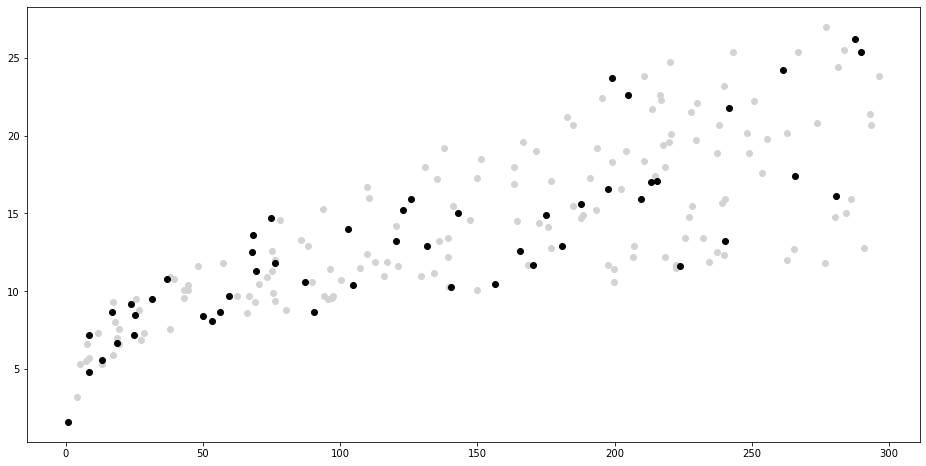

In [19]:
X_plot = pd.DataFrame({'TV': np.arange(min(data['TV']),max(data['TV']),1)})
y_single_plot = reg_single.predict(X_plot)
y_poly_plot = reg_single_poly.predict(X_plot)

plt.figure(figsize=(16, 8))
plt.scatter(X_train['TV'], y_train, c='lightgray')
plt.scatter(X_val['TV'], y_val, c='black')
plt.plot(X_plot, y_single_plot, c='lightblue', linewidth=2, label='single linear')
plt.plot(X_plot, y_poly_plot, c='blue', linewidth=2, label='polynomial')

plt.xlabel("Money spent on TV ads ($)")
plt.ylabel("Sales ($)")
plt.legend()
plt.show()

### Model performance: Polynomial

In [ ]:
y_pred = reg_single_poly.predict(X_val_single)
evaluate_regression(y_pred, y_val)

### Polynomial Multiple linear regression (with interaction)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_multi = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
X_train_poly = poly_multi.fit_transform(X_train)

pd.DataFrame(X_train_poly, columns=poly_multi.get_feature_names_out()).head()

In [ ]:
reg_multi = Pipeline([
    ('poly', poly_multi),
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])
reg_multi.fit(X_train, y_train)
reg_multi.named_steps['regression'].coef_

#### Accuracy

In [ ]:
y_pred = reg_multi.predict(X_val)
evaluate_regression(y_pred, y_val)

### Regularization 

We can try to increase the complexity of our model as much as we can to see if the validation error gets even lower.

In [ ]:
overkill_poly = Pipeline([
    ('overkill_poly', PolynomialFeatures(degree=15, include_bias=True, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
overkill_poly.fit(X_train, y_train)
overkill_poly.named_steps['reg'].coef_

In [ ]:
y_pred = overkill_poly.predict(X_val)
evaluate_regression(y_val, y_pred)

Apparently not...  
Let's try a Ridge regression model instead

In [ ]:
from sklearn.linear_model import Ridge
ridge = Pipeline([
    ('overkill_poly', PolynomialFeatures(degree=15, include_bias=True, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])
ridge.fit(X_train, y_train)
ridge.named_steps['ridge'].coef_

In [ ]:
y_pred = ridge.predict(X_val)
evaluate_regression(y_val, y_pred)